Simply execute all cells to run this notebook to achieve the High cutoff.

Details:

Resnext 152 architecture

LR wamrup 15 epochs

CosineAnnealing scheduler

Added transformations

Total epochs: 120

Verification Threshold: 55


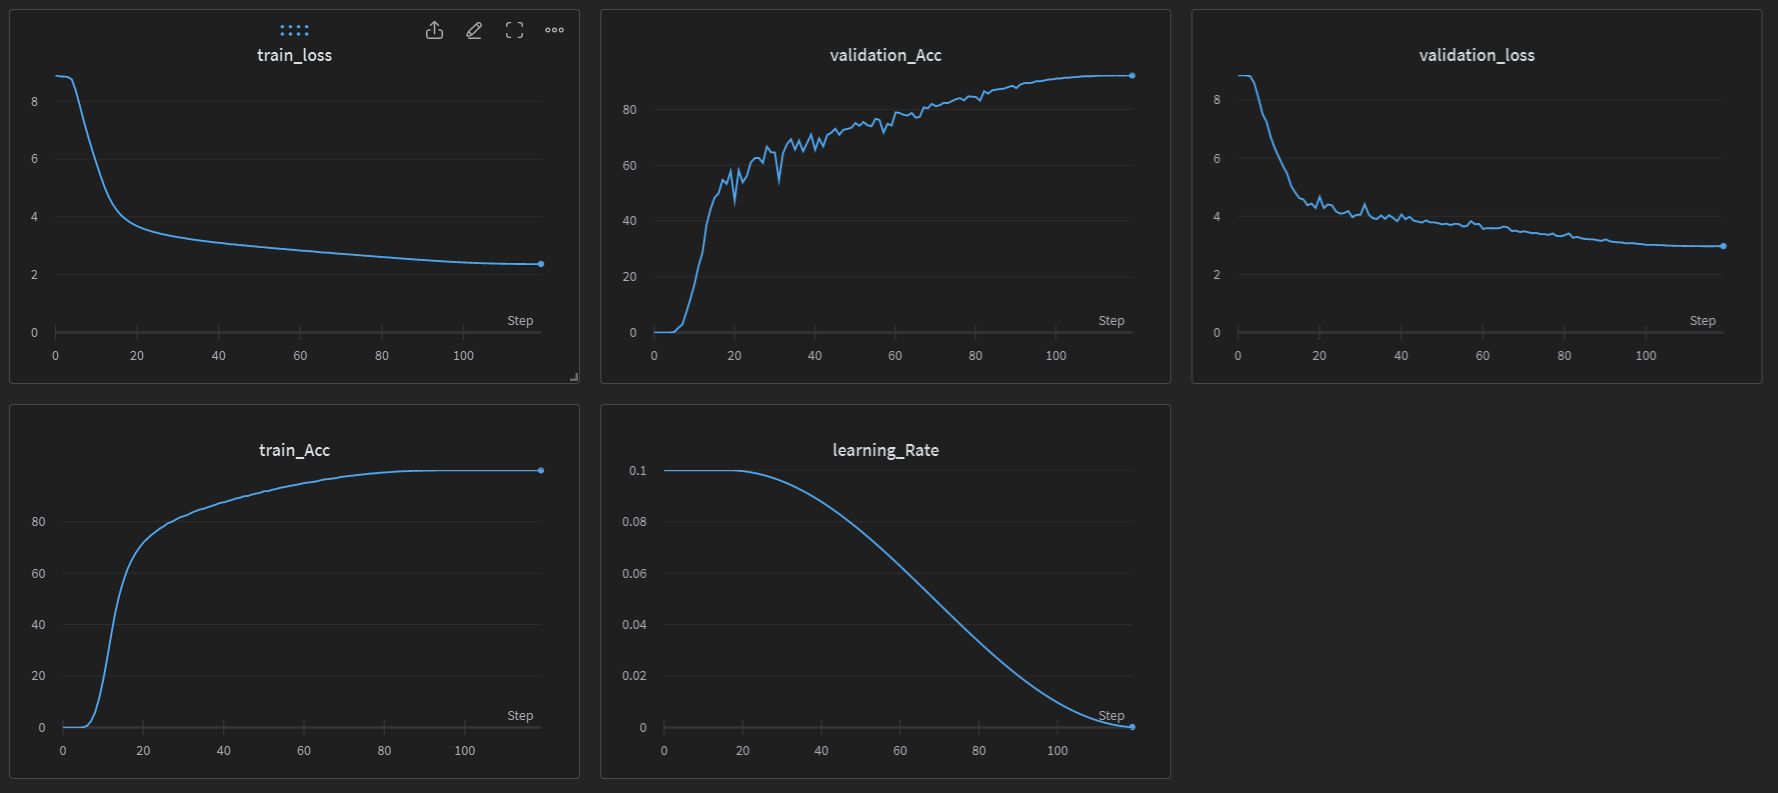

# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early! 


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7000 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have


# from GPUtil import showUtilization as gpu_usage
# gpu_usage()   

Mon Mar 20 00:24:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    57W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install torch
# !pip install torchsummaryX wandb --quiet
# !pip install speechpy
# !pip install torch-lr-scheduler

In [ ]:
!pip install wandb --quiet

In [ ]:
# !pip install wandb --quiet
# #!pip uninstall torch
# #!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install torchsummary
# !pip install tqdm
# !pip install -U scikit-learn
# !pip install matplotlib

In [ ]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import torch.nn as nn
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(torch.__version__)
print("Device: ", DEVICE)

True
1.13.1+cu116
Device:  cuda


In [ ]:
#from google.colab import drive # Link your drive if you are a colab user
#drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"sauravkambil","key":"##########"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# 
!sudo rm -r /content/data
!mkdir '/content/data'
!kaggle competitions download -c 11-785-s23-hw2p2-classification
!unzip -qo '11-785-s23-hw2p2-classification.zip' -d 'data'

!kaggle competitions download -c 11-785-s23-hw2p2-verification
!unzip -qo '11-785-s23-hw2p2-verification.zip' -d 'data'

11-785-s23-hw2p2-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
11-785-s23-hw2p2-verification.zip: Skipping, found more recently modified local copy (use --force to force download)


# Configs

In [ ]:
config = {
    'batch_size':64, # Increase this if your GPU can handle it
    'lr': 0.01,
    'epochs': 120,
    'stochastic_depth_probability':0.1,
    'rotation_angle':10,
    'horizontal_flip':0.5,
    'momentum': 0.9,
    'weight_decay':1e-4,
    'label_smoothing':0.2,
    'factor':0.5,
    'threshold_mode':'abs',
    'threshold':0.01,
    'patience':2, # 10 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In [ ]:
DATA_DIR    = "/content/data/11-785-s23-hw2p2-classification"# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train") 
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html
mean, std = torch.Tensor([0.5116, 0.4026, 0.3519]), torch.Tensor([0.2708, 0.2362, 0.2226])
train_transforms = torchvision.transforms.Compose([
    

    torchvision.transforms.RandomAffine(degrees=15,translate=(0.1,0.1)),
    torchvision.transforms.RandomAdjustSharpness(0.4, p=0.2),
    torchvision.transforms.ColorJitter(brightness=0.3,contrast=0.2,saturation=0.2,hue=0.0),
    torchvision.transforms.RandomPerspective(0.3, 0.3),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomGrayscale(p=0.09),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=mean, std=std),
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 8, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 8
)

In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

In [ ]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


## Data visualization

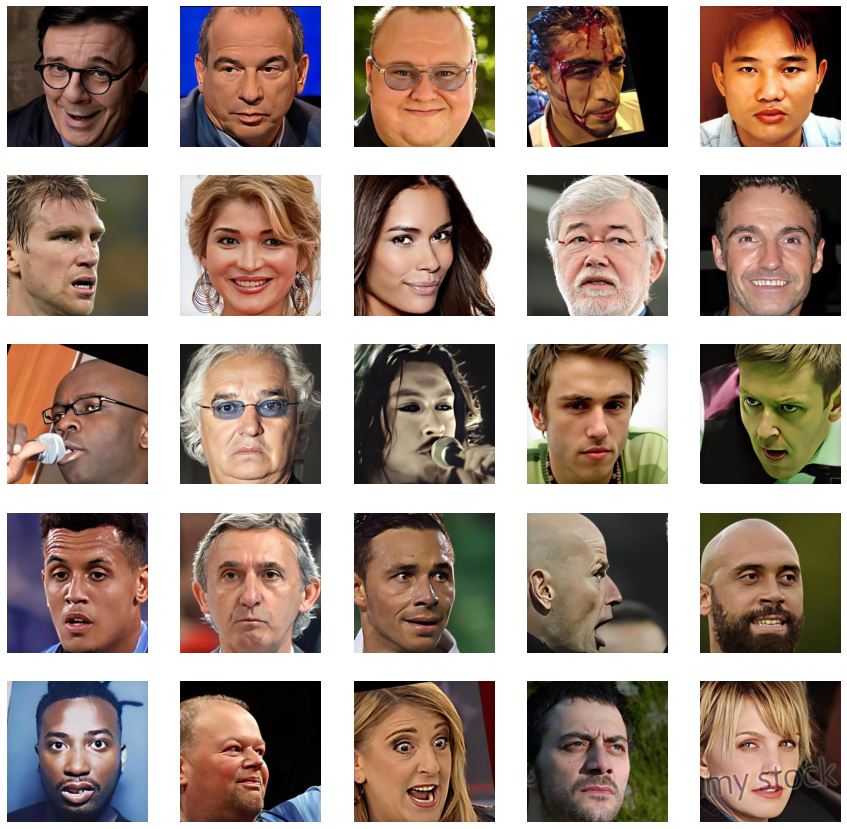

In [ ]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'], 
    shuffle     = True,
)

for data in dtl:
    x, y = data
    
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [ ]:
#class Network(torch.nn.Module):
    # """
    # The Very Low early deadline architecture is a 4-layer CNN.

    # The first Conv layer has 64 channels, kernel size 7, and stride 4.
    # The next three have 128, 256, and 512 channels. Each have kernel size 3 and stride 2.
    
    # Think about strided convolutions from the lecture, as convolutioin with stride= 1 and downsampling.
    # For stride 1 convolution, what padding do you need for preserving the spatial resolution? 
    # (Hint => padding = kernel_size // 2) - Why?)

    # Each Conv layer is accompanied by a Batchnorm and ReLU layer.
    # Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d.
    # Then, remove (Flatten?) these trivial 1x1 dimensions away.
    # Look through https://pytorch.org/docs/stable/nn.html 
    
    # TODO: Fill out the model definition below! 

    # Why does a very simple network have 4 convolutions?
    # Input images are 224x224. Note that each of these convolutions downsample.
    # Downsampling 2x effectively doubles the receptive field, increasing the spatial
    # region each pixel extracts features from. Downsampling 32x is standard
    # for most image models.

    # Why does a very simple network have high channel sizes?
    # Every time you downsample 2x, you do 4x less computation (at same channel size).
    # To maintain the same level of computation, you 2x increase # of channels, which 
    # increases computation by 4x. So, balances out to same computation.
    # Another intuition is - as you downsample, you lose spatial information. We want
    # to preserve some of it in the channel dimension.
    # """

    # def __init__(self, num_classes=7000):
    #     super().__init__()

    #     self.backbone = torch.nn.Sequential(
    #         torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4, padding=3),
    #         torch.nn.BatchNorm2d(64),
    #         torch.nn.ReLU(),

    #         torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
    #         torch.nn.BatchNorm2d(128),
    #         torch.nn.ReLU(),

    #         torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    #         torch.nn.BatchNorm2d(256),
    #         torch.nn.ReLU(),

    #         torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
    #         torch.nn.BatchNorm2d(512),
    #         torch.nn.ReLU(),

    #         torch.nn.AdaptiveAvgPool2d((1,1)),
    #         torch.nn.Flatten(),
    #     )

    #     self.cls_layer = torch.nn.Linear(in_features=512, out_features=num_classes)

    # def forward(self, x):
    #     x = self.backbone(x)
    #     x = self.cls_layer(x)
    #     return x

    
    # def forward(self, x, return_feats=False):
    #     """
    #     What is return_feats? It essentially returns the second-to-last-layer
    #     features of a given image. It's a "feature encoding" of the input image,
    #     and you can use it for the verification task. You would use the outputs
    #     of the final classification layer for the classification task.

    #     You might also find that the classification outputs are sometimes better
    #     for verification too - try both.
    #     """
    #     feats = self.backbone(x)
    #     out = self.cls_layer(feats)

    #     if return_feats:
    #         return feats
    #     else:
    #         return out
            

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1, bias=False):
        super().__init__()
        self.c = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias, groups=groups)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.bn(self.c(x))

# Bottleneck ResidualBlock 
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, first=False, cardinatlity=32):
        super().__init__()
        self.C = cardinatlity
        self.downsample = stride==2 or first
        res_channels = out_channels // 2
        self.c1 = ConvBlock(in_channels, res_channels, 1, 1, 0)
        self.c2 = ConvBlock(res_channels, res_channels, 3, stride, 1, self.C)
        self.c3 = ConvBlock(res_channels, out_channels, 1, 1, 0)

        self.relu = nn.ReLU()

        if self.downsample:
            self.p = ConvBlock(in_channels, out_channels, 1, stride, 0)


    def forward(self, x):
        f = self.relu(self.c1(x))
        f = self.relu(self.c2(f))
        f = self.c3(f)

        if self.downsample:
            x = self.p(x)

        h = self.relu(torch.add(f,x))

        return h

# ResNeXt
class ResNeXt(nn.Module):
    def __init__(
        self, 
        config_name : int, 
        in_channels : int = 3, 
        classes : int = 7000,
        C : int = 32 # cardinality
        ):
        super().__init__()

        configurations = {
            50 : [3, 4, 6, 3],
            101 : [3, 4, 23, 3],
            152 : [3, 8, 36, 3]
        }

        no_blocks = configurations[config_name]

        out_features = [256, 512, 1024, 2048]
        self.blocks = nn.ModuleList([ResidualBlock(64, 256, 1, True, cardinatlity=32)])

        for i in range(len(out_features)):
            if i > 0:
                self.blocks.append(ResidualBlock(out_features[i-1], out_features[i], 2, cardinatlity=C))
            for _ in range(no_blocks[i]-1):
                self.blocks.append(ResidualBlock(out_features[i], out_features[i], 1, cardinatlity=C))
        
        self.conv1 = ConvBlock(in_channels, 64, 7, 2, 3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, classes)
        self.drop = nn.Dropout(p=0.15)
        self.relu = nn.ReLU()
        
        self.init_weight()
        
    def forward(self, x, return_feats=False):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        for block in self.blocks:
            x = block(x)

        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        feats = self.drop(feats)
        out = self.fc(feats)
        if return_feats:
            return feats
        else:
            return out

    def init_weight(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)


In [ ]:
# #@title
# from torch.nn.modules.pooling import AdaptiveAvgPool2d
# from torch.nn.modules.activation import ReLU
# from torch.nn.modules.batchnorm import BatchNorm2d

# class convnext_block(torch.nn.Module):
#   def __init__(self,in_channels,out_channels):
#     super().__init__()

#     #block 1
#     self.block_1 = torch.nn.Sequential(
#          torch.nn.Conv2d(in_channels=in_channels,out_channels=out_channels[0],kernel_size=7,stride=1,groups=in_channels,padding=(3,3)),
#          torch.nn.BatchNorm2d(out_channels[-1]), 
#          torch.nn.Conv2d(in_channels=out_channels[0],out_channels=out_channels[1],kernel_size=1,stride=1),
#          torch.nn.GELU(),
#          torch.nn.Conv2d(in_channels=out_channels[1],out_channels=out_channels[2],kernel_size=1,stride=1))
#     self.stochastic_depth_1 = torchvision.ops.StochasticDepth(p=config['stochastic_depth_probability'],mode='batch')

#     #block 2
#     self.block_2 = torch.nn.Sequential(
#          torch.nn.Conv2d(in_channels=out_channels[2],out_channels=out_channels[0],kernel_size=7,stride=1,groups=out_channels[2],padding=(3,3)),
#          torch.nn.BatchNorm2d(out_channels[-1]), #layernorm later
#          torch.nn.Conv2d(in_channels=out_channels[0],out_channels=out_channels[1],kernel_size=1,stride=1),
#          torch.nn.GELU(),
#          torch.nn.Conv2d(in_channels=out_channels[1],out_channels=out_channels[2],kernel_size=1,stride=1))
#     self.stochastic_depth_2 = torchvision.ops.StochasticDepth(p=config['stochastic_depth_probability'],mode='batch')

#     #block 3
#     self.block_3 = torch.nn.Sequential(
#          torch.nn.Conv2d(in_channels=out_channels[2],out_channels=out_channels[0],kernel_size=7,stride=1,groups=out_channels[2],padding=(3,3)),
#          torch.nn.BatchNorm2d(out_channels[-1]), #layernorm later
#          torch.nn.Conv2d(in_channels=out_channels[0],out_channels=out_channels[1],kernel_size=1,stride=1),
#          torch.nn.GELU(),
#          torch.nn.Conv2d(in_channels=out_channels[1],out_channels=out_channels[2],kernel_size=1,stride=1))
#     self.stochastic_depth_3 = torchvision.ops.StochasticDepth(p=config['stochastic_depth_probability'],mode='batch')

#     #array of all blocks and stochastic depth
#     self.block_array=[self.block_1,self.block_2,self.block_3]
#     self.stc_array=[self.stochastic_depth_1,self.stochastic_depth_2,self.stochastic_depth_3]

#   def forward_block(self,x,i):
#     res = x
#     out = self.block_array[i](x)
#     out = res + self.stc_array[i](out)
#     return out
    
#   def forward(self,x):
#     for i in range(len(self.block_array)):
#       self.x=self.forward_block(x,i)
#     return self.x
#     # return x+self.block(x)

# class conv_norm(torch.nn.Module):
#   def __init__(self,in_channels,out_channels):
#     super().__init__()
#     self.in_channels=in_channels
#     self.out_channels=out_channels

#     self.model=torch.nn.Sequential(
#         torch.nn.BatchNorm2d(in_channels), #layernorm later
#         torch.nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=2,stride=2)
#         )
#   def forward(self,x):
#     return self.model(x)
                
# class ConvNext(torch.nn.Module):
#   def __init__(self,num_classes=7000):
#     super().__init__()
#     self.num_classes=num_classes
#     self.backbone=torch.nn.Sequential(
#         #stem
#         torch.nn.Conv2d(in_channels=3,out_channels=96,kernel_size=4,stride=4),
#         torch.nn.BatchNorm2d(96),  

#         #Res2 block 
#         convnext_block(in_channels=96,out_channels=[96,384,96]),
#         conv_norm(96,192),
        
#         #Res3 block 
#         convnext_block(in_channels=192,out_channels=[192,768,192]),
#         conv_norm(192,384),

#         #Res4 block 
#         convnext_block(in_channels=384,out_channels=[384,1536,384]),
#         convnext_block(in_channels=384,out_channels=[384,1536,384]),
#         convnext_block(in_channels=384,out_channels=[384,1536,384]),
#         conv_norm(384,768),
        
#         #Res5 block 
#         convnext_block(in_channels=768,out_channels=[768,3072,768]),
      
#         torch.nn.AdaptiveAvgPool2d((1,1)),
#         torch.nn.Flatten()
#             )
#         # #stem
#         # torch.nn.Conv2d(in_channels=3,out_channels=192,kernel_size=4,stride=4),
#         # torch.nn.BatchNorm2d(192),  

#         # #Res2 block 
#         # convnext_block(in_channels=192,out_channels=[192,768,192]),
#         # conv_norm(192,384),
        
#         # #Res3 block 
#         # convnext_block(in_channels=384,out_channels=[384,1536,384]),
#         # conv_norm(384,768),

#         # #Res4 block 
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # convnext_block(in_channels=768,out_channels=[768,3072,768]),
#         # conv_norm(768,1536),
        
#         # #Res5 block 
#         # convnext_block(in_channels=1536,out_channels=[1536,6144,1536]),
      
#         # torch.nn.AdaptiveAvgPool2d((1,1)),
#         # torch.nn.Flatten()
#         #     )
    
#     #final classifying layer
#     self.clf_layer=torch.nn.Linear(768,self.num_classes)

#   def forward(self,x,return_feats=False):
#     feats=self.backbone(x)
#     if return_feats: return feats
#     else: return self.clf_layer(feats)

In [ ]:


#@title
config_name = 152
resnext101 = ResNeXt(config_name, in_channels=3, classes=7000, C=32)
# image = torch.rand(1, 3, 224, 224)
# print(resnext101(image).shape)
model = ResNeXt(config_name, in_channels=3, classes=7000, C=32).to(DEVICE)
summary(model, (3, 224, 224))
# model=ConvNext(num_classes=len(train_dataset.classes)).to(DEVICE)
# model_summary=summary(model,(3,224,224))
m = torch.load("/checkpoint_epoch_17.pth")
model.load_state_dict(m["model_state_dict"])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         ConvBlock-3         [-1, 64, 112, 112]               0
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           8,192
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         ConvBlock-8          [-1, 128, 56, 56]               0
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]           4,608
      BatchNorm2d-11          [-1, 128, 56, 56]             256
        ConvBlock-12          [-1, 128, 56, 56]               0
             ReLU-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 256,

<All keys matched successfully>

# Setup everything for training

In [ ]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing =config['label_smoothing'])
# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'],momentum=config['momentum'],weight_decay=config['weight_decay'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                        mode='max',
#                                                        factor=config['factor'],
#                                                        patience=config['patience'],
#                                                        threshold_mode=config['threshold_mode'],
#                                                        threshold=config['threshold'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min = 1e-4)
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

# Let's train!

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()   

# Wandb

In [ ]:
wandb.login(key="f303efa63722be981833b9f7e8dd7bb0efd47e1f") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: nchinnal (idls23). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "RESNEXTonSteroids-by-SK", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

# Experiments

In [ ]:

best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
               'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 
    if epoch > 15: 
      scheduler.step()
    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      checkpoint_name='/checkpoint_epoch_'+str(epoch)+'.pth'
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, checkpoint_name)
      best_valacc = val_acc
      pth_filename='model_epoch_'+str(epoch)+'.pth'
      wandb.save(pth_filename)
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()


Epoch 1/50: 
Train Acc 99.9729%	 Train Loss 2.3639	 Learning Rate 0.0010


Val Acc 92.1875%	 Val Loss 2.9857
Saving model



Epoch 2/50: 
Train Acc 99.9729%	 Train Loss 2.3620	 Learning Rate 0.0010


Val Acc 92.1789%	 Val Loss 2.9813



Epoch 3/50: 
Train Acc 99.9743%	 Train Loss 2.3612	 Learning Rate 0.0010


Val Acc 92.1704%	 Val Loss 2.9876



Epoch 4/50: 
Train Acc 99.9750%	 Train Loss 2.3606	 Learning Rate 0.0010


Val Acc 92.2303%	 Val Loss 2.9881
Saving model



Epoch 5/50: 
Train Acc 99.9750%	 Train Loss 2.3598	 Learning Rate 0.0010


Val Acc 92.3018%	 Val Loss 2.9885
Saving model



Epoch 6/50: 
Train Acc 99.9743%	 Train Loss 2.3594	 Learning Rate 0.0010


Val Acc 92.2732%	 Val Loss 2.9833



Epoch 7/50: 
Train Acc 99.9736%	 Train Loss 2.3592	 Learning Rate 0.0010


Val Acc 92.2675%	 Val Loss 2.9875



Epoch 8/50: 
Train Acc 99.9743%	 Train Loss 2.3586	 Learning Rate 0.0010


Val Acc 92.2104%	 Val Loss 2.9842



Epoch 9/50: 
Train Acc 99.9750%	 Train Loss 2.3582	 Learning Rate 0.0009


Val Acc 92.2789%	 Val Loss 2.9848



Epoch 10/50: 
Train Acc 99.9750%	 Train Loss 2.3577	 Learning Rate 0.0009


Val Acc 92.2818%	 Val Loss 2.9866



Epoch 11/50: 
Train Acc 99.9750%	 Train Loss 2.3576	 Learning Rate 0.0009


Val Acc 92.3303%	 Val Loss 2.9851
Saving model



Epoch 12/50: 
Train Acc 99.9736%	 Train Loss 2.3573	 Learning Rate 0.0009


Val Acc 92.2561%	 Val Loss 2.9853



Epoch 13/50: 
Train Acc 99.9750%	 Train Loss 2.3569	 Learning Rate 0.0009


Val Acc 92.3246%	 Val Loss 2.9892



Epoch 14/50: 
Train Acc 99.9750%	 Train Loss 2.3566	 Learning Rate 0.0009


Val Acc 92.3389%	 Val Loss 2.9858
Saving model



Epoch 15/50: 
Train Acc 99.9750%	 Train Loss 2.3564	 Learning Rate 0.0008


Val Acc 92.3332%	 Val Loss 2.9865



Epoch 16/50: 
Train Acc 99.9750%	 Train Loss 2.3560	 Learning Rate 0.0008


Val Acc 92.3532%	 Val Loss 2.9881
Saving model



Epoch 17/50: 
Train Acc 99.9757%	 Train Loss 2.3560	 Learning Rate 0.0008


Val Acc 92.3989%	 Val Loss 2.9852
Saving model



Epoch 18/50: 
Train Acc 99.9750%	 Train Loss 2.3556	 Learning Rate 0.0008


Val Acc 92.3875%	 Val Loss 2.9873



Epoch 19/50: 
Train Acc 99.9764%	 Train Loss 2.3551	 Learning Rate 0.0007


Val Acc 92.3675%	 Val Loss 2.9849


Train:   3%|▎         | 71/2188 [00:18<08:40,  4.06it/s, acc=100.0000%, loss=2.3553, lr=0.0007, num_correct=4544]

KeyboardInterrupt: ignored

# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(5) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-classification-slackkaggle -f classification_early_submission.csv -m "early submission"

100% 507k/507k [00:02<00:00, 230kB/s]
Successfully submitted to Face Classification (Slack)

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
v_config = {
    'lr'               : 0.005,
    'epochs'           : 40,
    'sc_epochs'        : 30,
    'min_lr'           : 1e-3,
    'threshold'        : 0.2,
    'margin'           : 0.2,
    'sc_patience'      : 3,
    'sc_mode'          :'max',
    'sc_threshold_mode':'abs',
    'sc_threshold'     : 1e-3,
    'sc_factor'        : 0.5
}   

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 


100%|██████████| 360/360 [00:00<00:00, 6921.39it/s]

100%|██████████| 720/720 [00:00<00:00, 9050.77it/s]

100%|██████████| 960/960 [00:00<00:00, 10419.53it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain 
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings
    
    # After early submission, remove the previous line and uncomment the following code 

    threshold = 0.55 # Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
def fine_train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images, labels)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        v_scaler.scale(loss).backward() # This is a replacement for loss.backward()
        v_scaler.step(optimizer) # This is a replacement for optimizer.step()
        v_scaler.update() 

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))
    # scheduler.step(total_loss)

    return acc, total_loss

In [ ]:
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
class ArcFaceModel(torch.nn.Module):
    '''
    To train in a standard training loop make sure to modify the train function so you pass in the inputs and the labels
    i.e. output = model(images, labels)
    '''
    def __init__(self, model, margin=0.5, scaler=64, embedding_size=2048, num_classes=7000):
        super(ArcFaceModel, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes

        # small number to avoid invalid arcCos values
        self.eps = 1e-7
        
        # hyperparameters 
        self.margin = margin
        self.scaler = scaler

        # load classification model
        self.model = model

        # Initializing the arcface linear layer with the weights of the classifier from the trained CNN
        self.AFL_linear = torch.nn.Linear(embedding_size, num_classes, bias=False) # Why set bias=False? Check out the paper.
        with torch.no_grad():
          self.AFL_linear.weight.copy_(self.model.fc.weight)

        # Initializing utility functions for normalization, arcCos, cos and onehot encoding
        self.normalizer = torch.nn.functional.normalize
        self.arcCos = torch.acos
        self.cos = torch.cos
        self.one_hot = torch.nn.functional.one_hot

      
    def forward(self, x, labels):
        # Get face embedding
        embedding = self.model(x, return_feats=True)

        # TODO: normalize face embedding
        embedding =self.normalizer(embedding)

        # TODO: normalize linear layer weights
        with torch.no_grad():
          self.AFL_linear.weight = torch.nn.Parameter(self.normalizer(self.AFL_linear.weight))
        
        # TODO: take dot product to get cos theta, remember that Wx = ||W||||x||cos(\theta) and ||W|| = 1, ||x|| = 1
        cosine = self.AFL_linear(embedding)
        
        # We clamp the values to be a little higher than -1 and a little lower than one so we don't get nan values when we call arccos
        cosine = torch.clamp(cosine, min=-1.0+self.eps, max=1.0-self.eps)
   
        # TODO: get theta by performing arccos(cos(theta))
        theta = self.arcCos(cosine)

        # TODO: convert labels to one-hot
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes = 7000)
        # TODO: create a mask with m at positions with label 1 and 0 at positions with label 0
        margin_mask = torch.where(one_hot_labels == 1, self.margin, 0)
        # TODO: add margin m to theta
        theta_m = theta + margin_mask

        # calculate the cosine value for theta with margin added and scale with self.scaler
        logits = self.scaler*self.cos(theta_m) # this value is then passed to crossEntropyLoss in train loop to calculate arcface loss

        return logits

In [ ]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing= config['label_smoothing'])
# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum= config['momentum'], weight_decay= config['weight_decay'])
# TODO: Implement a scheduler (Optional but Highly Recommended)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'max', threshold_mode= 'abs', factor= config['factor'], patience= config['patience'], threshold= config['threshold'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= config['T_0'], eta_min= config['eta_min'])
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 40)
# scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 15, gamma= 1)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
v_scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

In [ ]:
m = torch.load("/checkpoint_epoch_118.pth")
model.load_state_dict(m["model_state_dict"])
lossmod = ArcFaceModel(model).to(DEVICE) 

NameError: ignored

In [ ]:
run = wandb.init(
    name = "Verification-RESNEXT-by-SK", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [ ]:
# verification eval
pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

Verification Accuracy = 0.6611111111111111


In [ ]:
best_valacc = 0.0

for epoch in range(v_config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = fine_train(lossmod, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(lossmod.model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
               'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently 

    # if epoch > 15:
    #   scheduler1.step()
    # else:
    #   scheduler2.step()
    
    scheduler1.step()
    

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      checkpoint_name='/checkpoint_epoch_'+str(epoch)+'.pth'

      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, f'./checkpoint{epoch}.pth')
      best_valacc = val_acc
      pth_filename='model_epoch_'+str(epoch)+'.pth'
      wandb.save(pth_filename)
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()

Train:   9%|▉         | 198/2188 [00:50<08:14,  4.03it/s, acc=0.0000%, loss=21.5937, lr=0.0050, num_correct=0]

KeyboardInterrupt: ignored

## Generate csv to submit to Kaggle

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11-785-s23-hw2p2-verification-slack -f verification_early_submission.csv -m "early submission"

100% 8.34k/8.34k [00:01<00:00, 4.64kB/s]
Successfully submitted to Face Verification (Slack)